# **Handwritten Digit Classifier**
In my first personal project for machine learning, I developed a convolutional neural network for the classification of the handwritten digits. The model is trained using the MNIST database containing 60,000 images of handwritten digits. 

This project is done as part of the fast.ai course "Practical Deep Learning for Coders" and uses certain functions from the fastai library. However, for learning purposes, the neural network is built from scratch to fully understand how a model is created and trained.

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# MNIST Dataset
The MNIST dataset contains 60,000  images of handwritten digits. For each digit from 0 to 9, the images are that are taken from the training set are combined into a rank-3 tensor. All of the images are then organized in a dictionary with the digit as the key and the rank-3 tensor as the value.

To visualize the entire dataset, the mean of all images for each digit is displayed, representing the "ideal" digit. 

In [ ]:
path = untar_data(URLs.MNIST)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [ ]:
(path/'training').ls()

(#10) [Path('training/5'),Path('training/7'),Path('training/9'),Path('training/6'),Path('training/0'),Path('training/4'),Path('training/3'),Path('training/1'),Path('training/8'),Path('training/2')]

In [ ]:
fns = {i: [fn for fn in (path/f'training/{i}').ls()] for i in range(10)}
img_tensors = {key: [tensor(Image.open(imagepath)) for imagepath in paths] for (key,paths) in fns.items()}
stacked_digits = {key: torch.stack(digit).float()/255 for (key,digit) in img_tensors.items()}

In [ ]:
mean_tensors = {key: img.mean(0) for (key,img) in stacked_digits.items()}

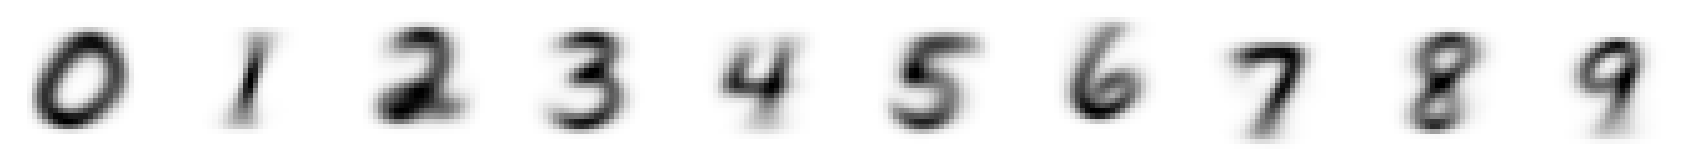

In [ ]:
show_images(list(mean_tensors.values()))

The same dictionary of rank-3 tensors is created for the validation set.

In [ ]:
valid_fns = {i: [fn for fn in (path/f'testing/{i}').ls()] for i in range(10)}
valid_img_tensors = {key: [tensor(Image.open(imagepath)) for imagepath in paths] for (key,paths) in valid_fns.items()}
valid_stacked_digits = {key: torch.stack(digit).float()/255 for (key,digit) in valid_img_tensors.items()}

# Training the Model
Stochastic gradient descent is implemented to train the model. The independent variable x is the images concatenated into a single rank-2 tensor and the dependent variable y is the labels. 



In [ ]:
train_x = torch.cat([digit for digit in stacked_digits.values()]).view(-1, 28*28)

In [ ]:
def create_label(rows, columns, index):
  labels = torch.zeros((rows,columns))
  labels[:,index] = 1
  return labels


In [ ]:
stacked_labels = {key: create_label(tensors.shape[0], len(stacked_digits), key) for (key,tensors) in stacked_digits.items()}

In [ ]:
train_y = torch.cat([label for label in stacked_labels.values()])
train_y.shape

torch.Size([60000, 10])

In [ ]:
valid_x = torch.cat([digit for digit in valid_stacked_digits.values()]).view(-1, 28*28)
valid_stacked_labels = {key: create_label(tensors.shape[0], len(valid_stacked_digits), key) for (key,tensors) in valid_stacked_digits.items()}
valid_y = torch.cat([label for label in valid_stacked_labels.values()])

In [ ]:
dset = list(zip(train_x,train_y))
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

The cross entropy loss function is used to measure the performance of the model.

In [ ]:
def mnist_loss(predictions, targets):
  predictions = predictions.softmax(dim=1)
  loss = -(targets * predictions.log()).sum() / len(predictions)
  return loss

In [ ]:
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,10))
bias = init_params(1)

In [ ]:
def linear1(xb): return xb@weights + bias

In [ ]:
xb,yb = first(dl)
preds = linear1(xb)
loss = mnist_loss(preds, yb)

In [ ]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

In [ ]:
def train_epoch(model, lr, params):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()

The model returns 10 predictions which correspond to the probability of an image belonging to every digit class. The maximum probability is thus the prediction of the model. The accuracy is determined by checking if the prediction matches the target.

In [ ]:
def batch_accuracy(predictions, targets):
    predictions = predictions.softmax(dim=1)
    predictions_i = predictions.max(1).indices
    targets_i = targets.max(1).indices
    return (predictions_i == targets_i).float().mean()

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
dls = DataLoaders(dl, valid_dl)

Nonlinearity is added between two linear layers, which makes our neural network. This is a rectified linear unit, which replaces every negative value with a zero. 

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,128),
    nn.ReLU(),
    nn.Linear(128,10)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy)

The model is complete. 60 epochs with a learning rate of 0.001 yields an accuracy of 86.54%. The full results are shown in the table below. 

In [ ]:
learn.fit(60, 0.001)

epoch,train_loss,valid_loss,batch_accuracy,time
0,2.358382,2.279210,0.148500,00:02
1,2.322724,2.242783,0.254100,00:01
2,2.287781,2.203944,0.393600,00:01
3,2.251134,2.161121,0.526100,00:01
4,2.210732,2.113471,0.600000,00:01
5,2.165181,2.060539,0.650600,00:01
6,2.114166,2.001935,0.677400,00:01
7,2.057389,1.937633,0.692200,00:01
8,1.995081,1.868239,0.700700,00:01
9,1.927819,1.794782,0.704800,00:01


# Furthering the Project
The accuracy of the model can be increased by experimenting with a different number of epochs and a different learning rate. A different loss function can be also be used. 

To move the model into production, the model can be turned into a simple web application where the user can upload a series of handwritten digits to obtain the predictions of the model as the output.